## Import simulation information

In [1]:
from simulations import layout1 as lay
from simulations import helpers as simh

## Import cadCAD

In [2]:
from cadCAD.configuration import Configuration
from cadCAD.configuration.utils import config_sim, access_block
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

## Import Data Processing Toolkit

In [3]:
import pandas as pd
import numpy as np
import copy

## View topology

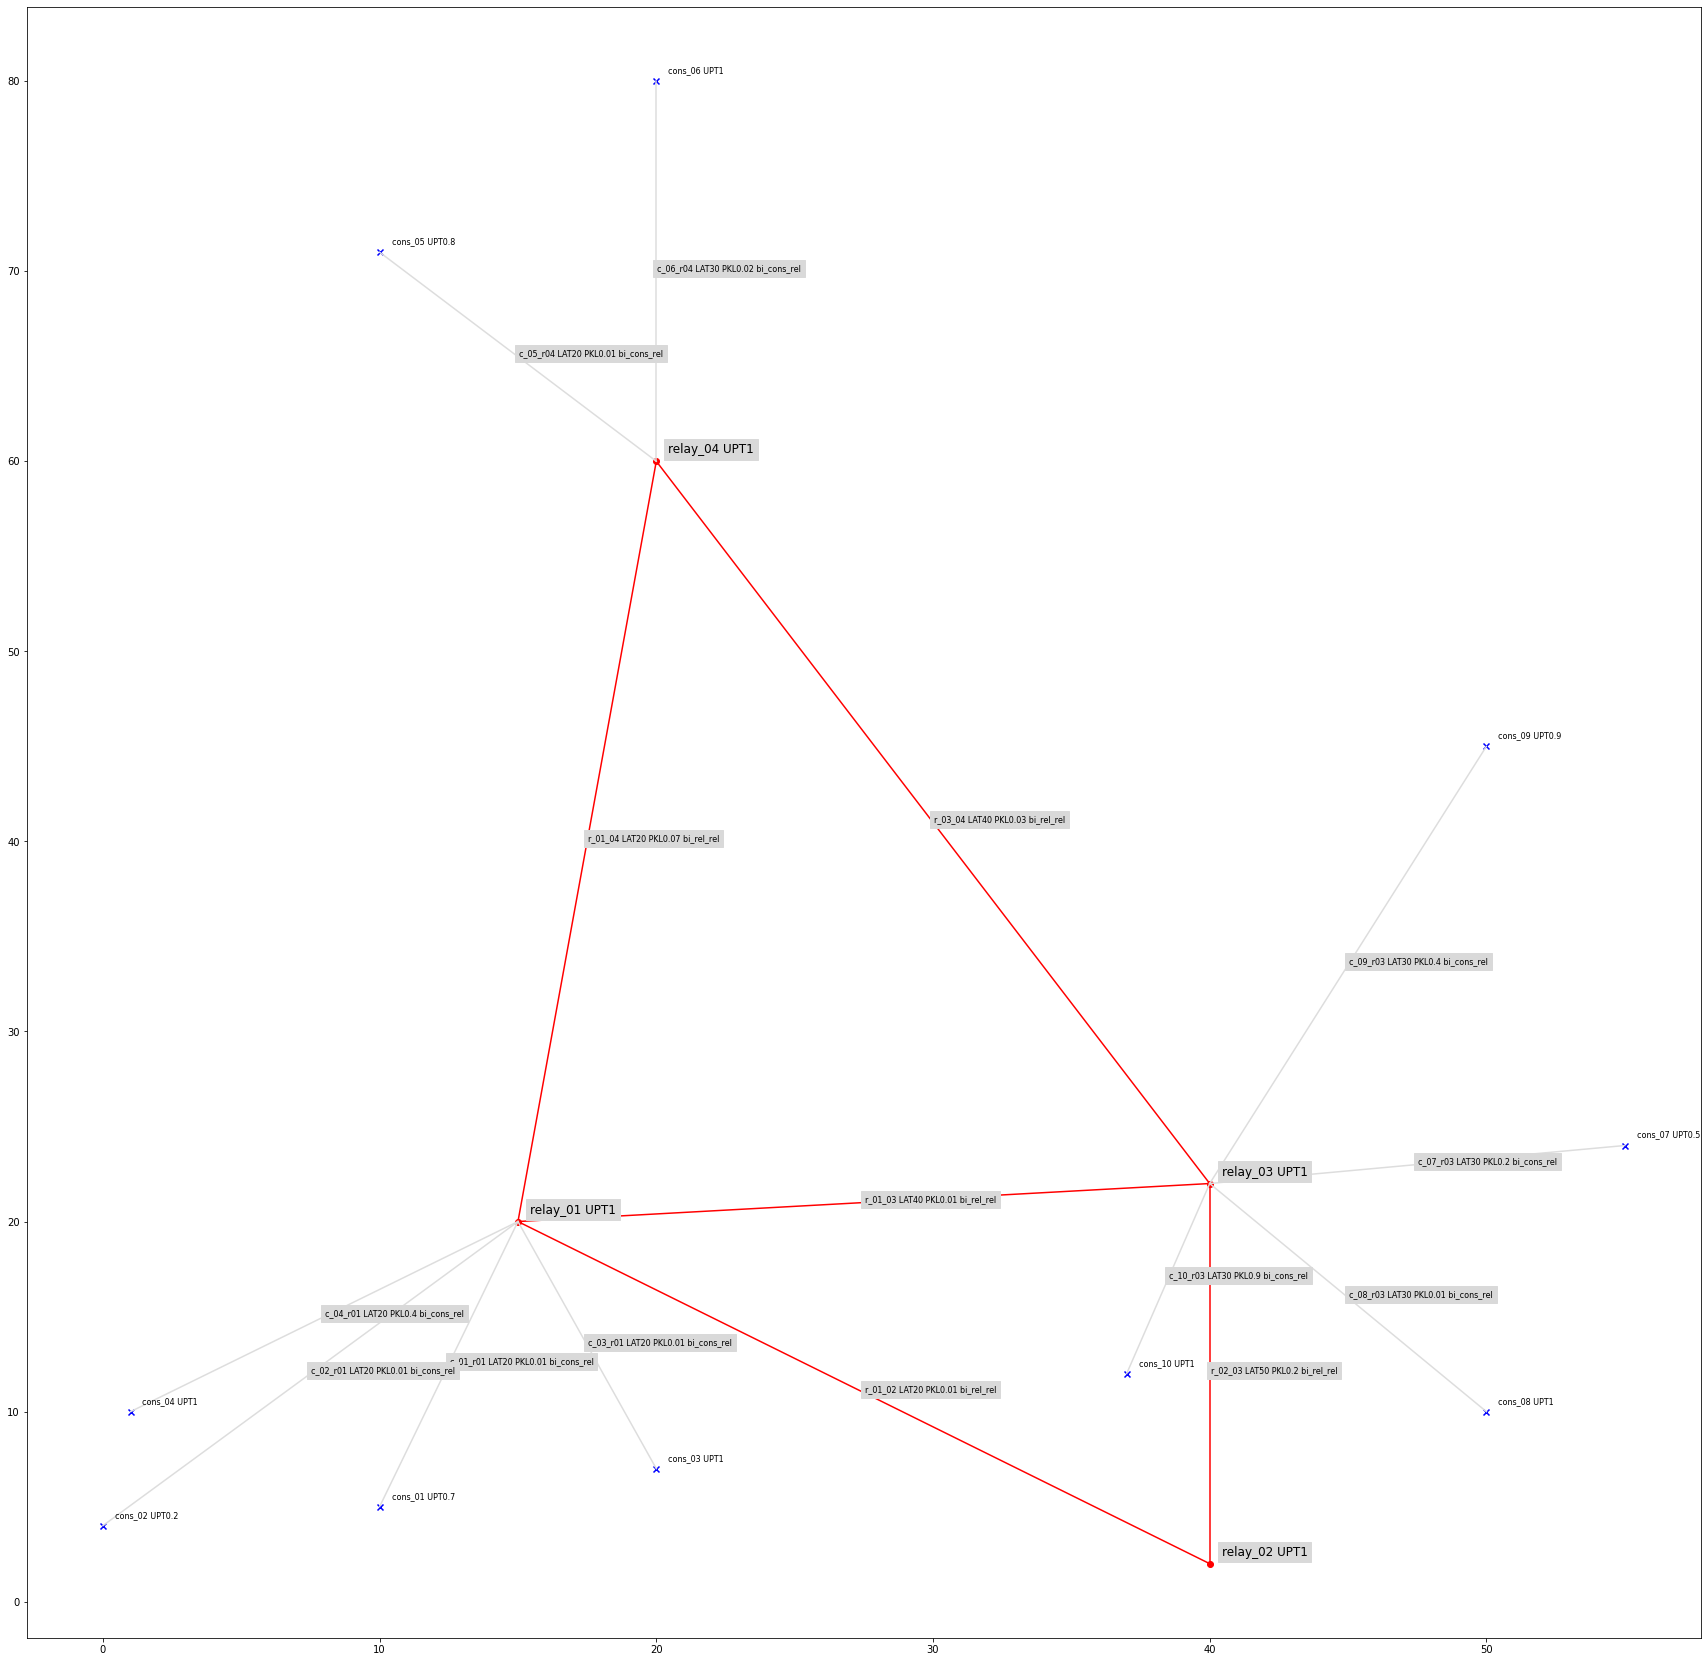

In [4]:
simh.show_topology(lay.layout)

In [5]:
initial_conditions = {
    'messages': {
        'to_be_sent': [
            {'to': 'cons_04', 'status': 'waiting', 'start': 40, 'message': 'mess_cons_04'},
            {'to': 'cons_10', 'status': 'waiting', 'start': 140, 'message': 'mess_cons_10'},
            {'to': 'cons_02', 'status': 'waiting', 'start': 40, 'message': 'mess_cons_02'},
            {'to': 'cons_05', 'status': 'waiting', 'start': 340, 'message': 'mess_cons_05'},
            {'to': 'cons_06', 'status': 'waiting', 'start': 340, 'message': 'mess_cons_06'},
            {'to': 'cons_09', 'status': 'waiting', 'start': 700, 'message': 'mess_cons_09'},
        ],
        'recieved': {}
    },
    'messages_in_transit': 0,
    'messages_in_dest': 0,
    'connections': simh.generate_adjecency_list(lay.layout),
    'temp': 0,
}

def stateupdate_messages(_params, substep, sH, state, _input):
    to_be_sent = state['messages']['to_be_sent']
    recieved = state['messages']['recieved']
    conns = state['connections']
    for msg in to_be_sent:
        to = msg['to']
        if msg['start'] < state['timestep']:
            if to not in recieved.keys():
                recieved[msg['to']] = set()
            if msg['message'] not in recieved[to]:
                recieved[to].add(msg['message'])
                for conn in conns[to]:
                    dest = conn['to']
                    latency = conn['latency']
                    pkl = conn['packet_loss']
                    print(f"""Forwarding {msg['message']} from {to} to {dest}""")
                    ## TODO Simulate packet loss and check for connection type
                    ## TODO Check for bidirectional types
                    ## TODO Simulate uptime
                    to_be_sent.append(copy.deepcopy(msg))
                    new_entry = to_be_sent[-1]
                    new_entry['start'] = new_entry['start'] + latency
                    new_entry['to'] = dest
            to_be_sent.remove(msg)
    return ('temp', 0)

def stateupdate_messages_in_transit(_params, substep, sH, state, _input):
    return ('messages_in_transit', _input['messages_in_transit'])

def stateupdate_messages_in_dest(_params, substep, sH, state, _input):
    return ('messages_in_dest', _input['messages_in_dest'])

def policy_count_messages(_params, substep, sH, state):
    messages_in_transit = len(state['messages']['to_be_sent'])
    messages_in_dest = 0
    for dest in state['messages']['recieved']:
        messages_in_dest += len(state['messages']['recieved'])
    return {'messages_in_transit': messages_in_transit, 'messages_in_dest': messages_in_dest}

partial_state_update_blocks = [
    { 
        'policies': {
            'count_messages': policy_count_messages
        },
        'variables': {
            'process_messages': stateupdate_messages,
            'update_messages_in_transit': stateupdate_messages_in_transit,
            'update_messages_in_dest': stateupdate_messages_in_dest
        }
    }
]

simulation_parameters = {
    'T': range(0, 1000, 10),
    'N': 1,
    'M': {}
}

config = Configuration(user_id="",
                       initial_state=initial_conditions, 
                       partial_state_update_blocks=partial_state_update_blocks, 
                       sim_config=simulation_parameters 
                      )

{'relay_01': [{'to': 'relay_02', 'latency': 20, 'packet_loss': 0.01, 'type': 'bi_rel_rel'}, {'to': 'relay_04', 'latency': 20, 'packet_loss': 0.07, 'type': 'bi_rel_rel'}, {'to': 'relay_03', 'latency': 40, 'packet_loss': 0.01, 'type': 'bi_rel_rel'}], 'relay_02': [{'to': 'relay_01', 'latency': 20, 'packet_loss': 0.01, 'type': 'bi_rel_rel'}, {'to': 'relay_03', 'latency': 50, 'packet_loss': 0.2, 'type': 'bi_rel_rel'}], 'relay_03': [{'to': 'relay_02', 'latency': 50, 'packet_loss': 0.2, 'type': 'bi_rel_rel'}, {'to': 'relay_04', 'latency': 40, 'packet_loss': 0.03, 'type': 'bi_rel_rel'}, {'to': 'relay_01', 'latency': 40, 'packet_loss': 0.01, 'type': 'bi_rel_rel'}], 'relay_04': [{'to': 'relay_03', 'latency': 40, 'packet_loss': 0.03, 'type': 'bi_rel_rel'}, {'to': 'relay_01', 'latency': 20, 'packet_loss': 0.07, 'type': 'bi_rel_rel'}], 'cons_01': [], 'cons_02': [], 'cons_03': [], 'cons_04': [], 'cons_05': [], 'cons_06': [], 'cons_07': [], 'cons_08': [], 'cons_09': [], 'cons_10': []}


In [6]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, ten1, ten2 = executor.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 0, 1, 5)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Forwarding mess_cons_04 from cons_04 to relay_01
Forwarding mess_cons_02 from cons_02 to relay_01
Forwarding mess_cons_04 from relay_01 to relay_02
Forwarding mess_cons_04 from relay_01 to relay_04
Forwarding mess_cons_04 from relay_01 to relay_03
Forwarding mess_cons_04 from relay_01 to cons_01
Forwarding mess_cons_04 from relay_01 to cons_02
Forwarding mess_cons_04 from relay_01 to cons_03
Forwarding mess_cons_04 from relay_01 to cons_04
Forwarding mess_cons_02 from relay_01 to relay_02
Forwarding mess_cons_02 from relay_01 to relay_04
Forwarding mess_cons_02 from relay_01 to relay_03


In [7]:
df = pd.DataFrame(raw_result)

In [8]:
df

,messages,messages_in_transit,messages_in_dest,connections,temp,simulation,run,substep,timestep
0,"{'to_be_sent': [{'to': 'cons_04', 'status': 'w...",0,0,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,1,0,0
1,"{'to_be_sent': [{'to': 'cons_04', 'status': 'w...",6,0,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,1
2,"{'to_be_sent': [{'to': 'cons_04', 'status': 'w...",6,0,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,11
3,"{'to_be_sent': [{'to': 'cons_04', 'status': 'w...",6,0,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,21
4,"{'to_be_sent': [{'to': 'cons_04', 'status': 'w...",6,0,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,31
...,...,...,...,...,...,...,...,...,...
96,"{'to_be_sent': [], 'recieved': {'cons_04': {'m...",0,196,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,951
97,"{'to_be_sent': [], 'recieved': {'cons_04': {'m...",0,196,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,961
98,"{'to_be_sent': [], 'recieved': {'cons_04': {'m...",0,196,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,971
99,"{'to_be_sent': [], 'recieved': {'cons_04': {'m...",0,196,"{'relay_01': [{'to': 'relay_02', 'latency': 20...",0,0,2,1,981


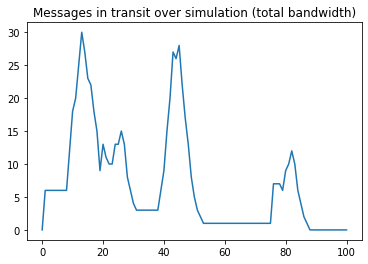

In [9]:
df['messages_in_transit'].plot(title="Messages in transit over simulation (total bandwidth)")

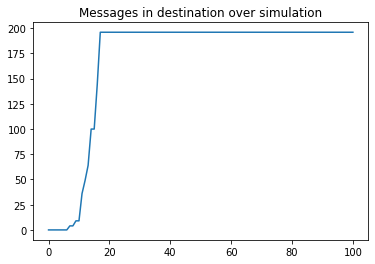

In [10]:
df['messages_in_dest'].plot(title="Messages in destination over simulation")